<h1 style="text-align: center; color: #E30613;"><b><i>Entraînement avec DziriBert sur les Données de Sentiments</i></b></h1>

<p style="font-size: 18px;">
Ce notebook présente un workflow complet pour l'entraînement et l'évaluation d'un modèle de classification des sentiments en utilisant <span style="color: #28A745;"><b>DziriBert</b></span>, un modèle de langage pré-entraîné.
</p>

### <span style="color: #28A745;">**Objectifs :**</span>
1. Charger et prétraiter les données textuelles.
2. Encoder les étiquettes des sentiments.
3. Utiliser un tokenizer pour préparer les données pour le modèle.
4. Diviser les données en ensembles d'entraînement, de validation et de test.
5. Entraîner le modèle avec des techniques avancées comme le dropout et l'early stopping.
6. Évaluer les performances du modèle à l'aide de métriques comme la matrice de confusion et le rapport de classification.
7. Visualiser les courbes de pertes et d'accuracy pour analyser les performances.

### <span style="color: #28A745;">**Plan du Notebook :**</span>
1. **Introduction et Bibliothèques nécessaires**  
    Importation des bibliothèques et configuration de l'environnement.
    
2. **Chargement et Prétraitement des Données**  
    Nettoyage des données et préparation des étiquettes.

3. **Tokenization et Préparation des Données**  
    Utilisation du tokenizer DziriBert et création des ensembles d'entraînement, de validation et de test.

4. **Entraînement du Modèle**  
    Entraînement avec des techniques comme l'early stopping et le dropout.

5. **Évaluation et Visualisation**  
    Analyse des performances avec des métriques et des visualisations.

6. **Conclusion**  
    Résumé des résultats et perspectives d'amélioration.

# <span style="color: #E30613;">**DziriBert**</span>

## <span style="color: #28A745;">**Bibiliothèques nécessaires**</span>

In [20]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import functional as F
from torch import nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random

## <span style="color: #28A745;">**Utilisation de GPU**</span>

In [21]:
# ✅ Configuration du device GPU uniquement
assert torch.cuda.is_available(), "CUDA GPU is not available."
device = torch.device("cuda")

## <span style="color: #28A745;">**Chargement des Données**</span>

In [22]:
# 📁 Chargement des données
df = pd.read_csv("/content/Results/Comments_clean.csv").dropna(subset=["Comments"])

## <span style="color: #28A745;">**Encodage des étiquettes**</span>

In [23]:
# 🎯 Encodage des étiquettes
label_encoder = LabelEncoder()
df["Sentiments_encoded"] = label_encoder.fit_transform(df["Sentiments"])
num_labels = len(label_encoder.classes_)

## <span style="color: #28A745;">**Tokenizer, Split dataset (Train 70%, Test 20%, Val 10%)**</span>

In [24]:
tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# ✂️ Split dataset (Train 70%, Test 20%, Val 10%)
dataset = SentimentDataset(df["Comments"].values, df["Sentiments_encoded"].values, tokenizer)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
val_size = total_size - train_size - test_size
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

## <span style="color: #28A745;">**Chargement du modèle avec dropout custom**</span>

In [25]:
"""
# Chargement du modèle avec dropout custom
config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.45)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)
"""

config = AutoConfig.from_pretrained("alger-ia/dziribert", num_labels=num_labels, hidden_dropout_prob=0.4, output_attentions=True)
model = AutoModelForSequenceClassification.from_pretrained("alger-ia/dziribert", config=config)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## <span style="color: #28A745;">**Optimiseur et Scheduler**</span>

In [26]:
# Optimiseur et Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

## <span style="color: #28A745;">**Entraînement de Modèle**</span>

In [27]:
# 🔧 Entraînement avec Early Stopping
best_val_loss = float("inf")
patience, patience_counter = 2, 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\n🟢 Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"✅ Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/Results/best_model_DziriBert.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break


🟢 Epoch 1/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]


✅ Train Loss: 0.8979 | Acc: 0.5397 - Val Loss: 0.4986 | Acc: 0.8044

🟢 Epoch 2/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.46it/s]


✅ Train Loss: 0.4575 | Acc: 0.8169 - Val Loss: 0.3588 | Acc: 0.8760

🟢 Epoch 3/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.35it/s]


✅ Train Loss: 0.3096 | Acc: 0.8814 - Val Loss: 0.3475 | Acc: 0.8678

🟢 Epoch 4/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.18it/s]


✅ Train Loss: 0.2461 | Acc: 0.9083 - Val Loss: 0.3264 | Acc: 0.8650

🟢 Epoch 5/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.22it/s]


✅ Train Loss: 0.2097 | Acc: 0.9225 - Val Loss: 0.3429 | Acc: 0.8788

🟢 Epoch 6/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.16it/s]


✅ Train Loss: 0.1936 | Acc: 0.9288 - Val Loss: 0.3235 | Acc: 0.8871

🟢 Epoch 7/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.20it/s]


✅ Train Loss: 0.1555 | Acc: 0.9427 - Val Loss: 0.3356 | Acc: 0.8843

🟢 Epoch 8/10


Validation: 100%|██████████| 23/23 [00:02<00:00,  8.06it/s]

✅ Train Loss: 0.1410 | Acc: 0.9470 - Val Loss: 0.3482 | Acc: 0.8926
⛔ Early stopping triggered.


## <span style="color: #28A745;">**Évaluation finale**</span>

In [28]:
# Évaluation finale
model.load_state_dict(torch.load("/content/Results/best_model_DziriBert.pt"))
model.eval()
all_preds, all_labels = [], []

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

print("🔍 Rapport de classification pour DziriBert:")
print(f"📉 Train Loss Finale: {train_loss:.4f}") # Affichage des pertes finales pour entrainement
print(f"📉 Validation Loss Finale: {val_loss:.4f}") # Affichage des pertes finales pour validation
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

🔍 Rapport de classification pour DziriBert:
📉 Train Loss Finale: 0.1410
📉 Validation Loss Finale: 0.3482
              precision    recall  f1-score   support

     Negatif       0.90      0.90      0.90       160
      Neutre       0.88      0.86      0.87       244
     Positif       0.93      0.95      0.94       318

    accuracy                           0.91       722
   macro avg       0.90      0.90      0.90       722
weighted avg       0.91      0.91      0.91       722



## <span style="color: #28A745;">**Courbes des pertes**</span>

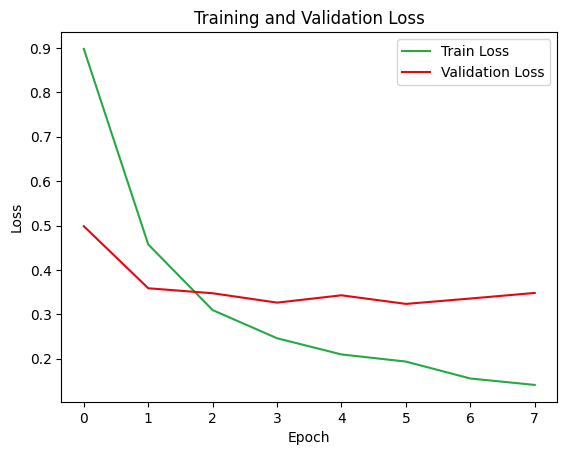

In [29]:
# Courbes des pertes
plt.plot(train_losses, label="Train Loss", color='#28A745')  # Vert
plt.plot(val_losses, label="Validation Loss", color='#E30613')  # Rouge
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

plt.legend()
plt.show()

## <span style="color: #28A745;">**Matrice de confusion**</span>

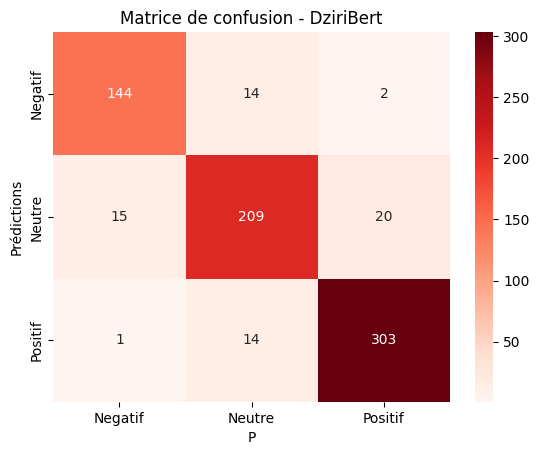

In [30]:
# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Reds")
plt.xlabel("P")
plt.ylabel("Prédictions")
plt.title("Matrice de confusion - DziriBert")
plt.show()

<h3 style="text-align: center; color: #E30613;"><b><i>Développé par: OUARAS Khelil Rafik</i></b></h3>